# Sentiment Analysis in Social Media Texts

In [26]:
import pandas as pd
import numpy as np
import re
import nltk
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# Downloads
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese')).union(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
# Função de pré-processamento
def preprocess(text):
    text = str(text)
    text = unidecode(text)
    text = re.sub(r'https?://\S+|@\w+|#[\w-]+', '', text)  # Remove links, menções, hashtags
    text = re.sub(r'\W|\d', ' ', text.lower())
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return ' '.join(tokens)

# Carregar dados
df = pd.read_csv("improved_sentiment_data.csv")
df.head(5)

,text,sentiment
0,Happy with the new park.,neutral
1,Feeling sad about the pollution.,neutral
2,Happy with the new park.,neutral
3,The weather is amazing.,neutral
4,The public services are great.,neutral


In [29]:
# Pré-processar
df.dropna(subset=['text', 'sentiment'], inplace=True)
df['text_clean'] = df['text'].apply(preprocess)

# Codificar rótulos
le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['sentiment'])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    df['text_clean'], df['sentiment_encoded'], test_size=0.2, stratify=df['sentiment_encoded'], random_state=42
)

# Vetorizador separado
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.85, sublinear_tf=True)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_vec, y_train)

In [30]:
# Treinar modelo de Regressão Logística
model = LogisticRegression(max_iter=1000)
model.fit(X_train_bal, y_train_bal)

# Avaliar modelo
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=le.classes_)

# Exibir resultados
print(f"Acurácia: {accuracy:.2f}")
print(f"F1-score: {f1:.2f}")
print("Matriz de Confusão:")
print(conf_matrix)
print("Relatório de Classificação:")
print(class_report)

Acurácia: 0.41
F1-score: 0.39
Matriz de Confusão:
[[ 54 107  52]
 [ 31 127  56]
 [ 35 100  79]]
Relatório de Classificação:
              precision    recall  f1-score   support

    negative       0.45      0.25      0.32       213
     neutral       0.38      0.59      0.46       214
    positive       0.42      0.37      0.39       214

    accuracy                           0.41       641
   macro avg       0.42      0.41      0.39       641
weighted avg       0.42      0.41      0.39       641




✅ Modelo salvo com sucesso!


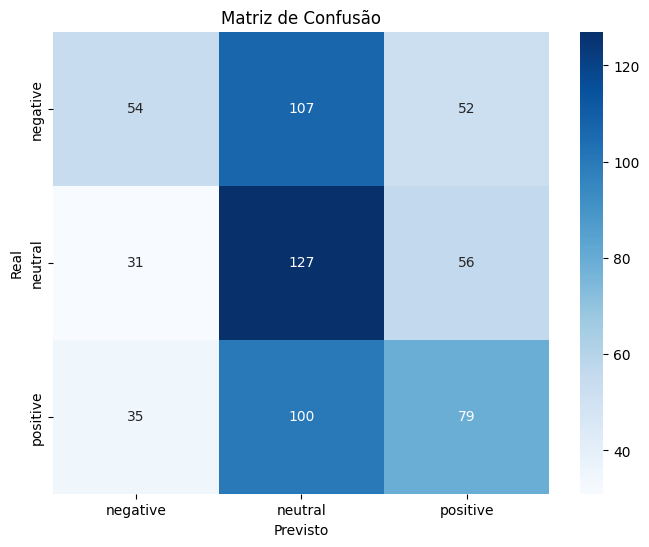

In [31]:
# Salvar modelo e label encoder
final_pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('clf', model)
])

final_pipeline.fit(df['text_clean'], df['sentiment_encoded'])  # Treina com todos os dados

joblib.dump(final_pipeline, 'sentiment_model.joblib')
joblib.dump(le, 'label_encoder.joblib')
print("\n✅ Modelo salvo com sucesso!")

# Visualizar matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Análise de Sentimento: Técnicas Implementadas no Código

O código Python fornecido implementa um fluxo completo de Machine Learning para análise de sentimento em texto. Abaixo estão as técnicas utilizadas, descritas em detalhes:

### 1. Importações de Bibliotecas

* **`pandas`**: Usada para manipulação e análise de dados tabulares (DataFrames).
* **`numpy`**: Fornece suporte para arrays e operações numéricas eficientes.
* **`re`**: Módulo para operações com expressões regulares, essencial para a limpeza de texto.
* **`nltk`**: (Natural Language Toolkit) Biblioteca para processamento de linguagem natural.
* **`joblib`**: Usada para salvar e carregar modelos treinados e outros objetos Python.
* **`seaborn` e `matplotlib.pyplot`**: Bibliotecas para visualização de dados, especialmente para a matriz de confusão.
* **`unidecode`**: Converte caracteres acentuados ou especiais para sua representação ASCII mais próxima (ex: "ação" para "acao").
* **`nltk.corpus.stopwords`**: Contém uma lista de palavras comuns (stopwords) que são frequentemente removidas do texto.
* **`sklearn.model_selection.train_test_split`**: Divide o conjunto de dados em subconjuntos de treinamento e teste.
* **`sklearn.preprocessing.LabelEncoder`**: Converte rótulos categóricos em rótulos numéricos (0, 1, 2...).
* **`sklearn.pipeline.Pipeline`**: Permite encadear várias etapas de processamento de dados e modelagem em um único objeto, garantindo que as transformações sejam aplicadas consistentemente.
* **`sklearn.feature_extraction.text.TfidfVectorizer`**: Converte uma coleção de documentos brutos em uma matriz de recursos TF-IDF.
* **`sklearn.metrics`**: Módulo que oferece diversas métricas para avaliar o desempenho do modelo (accuracy_score, classification_report, confusion_matrix, f1_score).
* **`sklearn.linear_model.LogisticRegression`**: Implementa o algoritmo de Regressão Logística, um modelo linear para classificação.
* **`imblearn.over_sampling.SMOTE`**: (Synthetic Minority Over-sampling Technique) Técnica de reamostragem para lidar com desequilíbrio de classes.

### 2. Download de Dados NLTK

* **`nltk.download('stopwords')`**: Baixa as palavras irrelevantes (stopwords) para vários idiomas, neste caso, português e inglês.
* **`stop_words = set(stopwords.words('portuguese')).union(set(stopwords.words('english')))`**: Cria um conjunto único de stopwords em português e inglês para remoção eficiente. Usar um `set` melhora a performance da busca.

### 3. Pré-processamento de Texto (`preprocess` function)

Esta função é crucial para limpar e normalizar o texto antes da vetorização:

* **`text = str(text)`**: Garante que a entrada seja uma string.
* **`text = unidecode(text)`**: Remove acentos e caracteres especiais, padronizando o texto (ex: "Olá" -> "Ola").
* **`text = re.sub(r'https?://\S+|@\w+|#[\w-]+', '', text)`**: Remove padrões comuns em texto de redes sociais:
    * `https?://\S+`: URLs (links).
    * `@\w+`: Menções de usuários (ex: `@fulano`).
    * `#[\w-]+`: Hashtags (ex: `#exemplo`).
* **`text = re.sub(r'\W|\d', ' ', text.lower())`**:
    * `text.lower()`: Converte todo o texto para minúsculas, garantindo que "Amor" e "amor" sejam tratados como a mesma palavra.
    * `re.sub(r'\W|\d', ' ', ...)`: Remove caracteres não alfanuméricos (`\W`) e dígitos (`\d`), substituindo-os por um espaço. Isso ajuda a isolar as palavras.
* **`tokens = text.split()`**: Divide o texto em uma lista de palavras (tokens).
* **`tokens = [t for t in tokens if t not in stop_words and len(t) > 2]`**: Filtra os tokens:
    * `t not in stop_words`: Remove palavras comuns que não adicionam significado ao sentimento (ex: "o", "a", "de", "e").
    * `len(t) > 2`: Remove palavras muito curtas (geralmente ruído ou caracteres residuais).
* **`return ' '.join(tokens)`**: Junta os tokens limpos de volta em uma única string.

### 4. Carregamento e Preparação Inicial dos Dados

* **`df = pd.read_csv("improved_sentiment_data.csv")`**: Carrega os dados de um arquivo CSV.
* **`df.dropna(subset=['text', 'sentiment'], inplace=True)`**: Remove linhas onde as colunas 'text' ou 'sentiment' possuem valores nulos. Isso é uma etapa importante de **limpeza de dados**.
* **`df['text_clean'] = df['text'].apply(preprocess)`**: Aplica a função de pré-processamento `preprocess` a cada texto na coluna 'text', criando uma nova coluna `text_clean` com os textos limpos.

### 5. Codificação de Rótulos (Label Encoding)

* **`le = LabelEncoder()`**: Inicializa o codificador de rótulos.
* **`df['sentiment_encoded'] = le.fit_transform(df['sentiment'])`**: Converte os rótulos de sentimento categóricos (ex: 'positivo', 'negativo', 'neutro') em valores numéricos inteiros (ex: 0, 1, 2). Isso é necessário porque os algoritmos de Machine Learning geralmente trabalham com entradas numéricas. `fit_transform` aprende os mapeamentos e os aplica.

### 6. Divisão de Dados (Train-Test Split)

* **`X_train, X_test, y_train, y_test = train_test_split(...)`**: Divide o conjunto de dados em subconjuntos para treinamento e teste.
    * `df['text_clean']`: Os dados de entrada (features) para o modelo.
    * `df['sentiment_encoded']`: Os rótulos de saída (target).
    * `test_size=0.2`: 20% dos dados serão usados para teste, 80% para treinamento.
    * **`stratify=df['sentiment_encoded']`**: Esta é uma técnica crucial para garantir que a proporção de classes no conjunto de treinamento e teste seja a mesma que no conjunto de dados original. Isso é especialmente importante em conjuntos de dados desbalanceados para evitar que um dos conjuntos tenha poucas ou nenhuma amostra de uma classe minoritária.
    * `random_state=42`: Garante a reprodutibilidade da divisão.

### 7. Vetorização de Texto (TF-IDF)

* **`vectorizer = TfidfVectorizer(...)`**: Transforma o texto limpo em representações numéricas que o modelo pode entender.
    * **`ngram_range=(1, 2)`**: Inclui tanto palavras únicas (unigrams) quanto pares de palavras consecutivas (bigrams) como recursos. Bigrams podem capturar mais contexto (ex: "não gosto" é diferente de "gosto").
    * **`min_df=2`**: Ignora termos que aparecem em menos de 2 documentos. Isso ajuda a remover palavras muito raras que podem ser ruído ou irrelevantes.
    * **`max_df=0.85`**: Ignora termos que aparecem em mais de 85% dos documentos. Isso ajuda a remover palavras muito comuns (mesmo que não sejam stopwords) que podem não ter poder discriminatório (ex: "o" ou "e" se não foram totalmente removidos).
    * **`sublinear_tf=True`**: Aplica uma escala logarítmica à frequência de termos (TF), o que significa que o aumento da frequência de uma palavra tem um impacto menor nas pontuações TF-IDF. Ajuda a reduzir o impacto de palavras muito frequentes.
* **`X_train_vec = vectorizer.fit_transform(X_train)`**: `fit_transform` aprende o vocabulário e os pesos TF-IDF do conjunto de treinamento e depois o transforma.
* **`X_test_vec = vectorizer.transform(X_test)`**: `transform` aplica o vocabulário e os pesos TF-IDF *aprendidos no conjunto de treinamento* ao conjunto de teste. É fundamental não usar `fit_transform` no conjunto de teste para evitar vazamento de dados (data leakage).

### 8. Balanceamento de Classes (SMOTE)

* **`smote = SMOTE(random_state=42)`**: Inicializa o algoritmo SMOTE.
* **`X_train_bal, y_train_bal = smote.fit_resample(X_train_vec, y_train)`**: Aplica SMOTE ao conjunto de treinamento. Esta é uma técnica de **oversampling**, que gera amostras sintéticas da(s) classe(s) minoritária(s) para balancear a distribuição de classes. Isso é crucial para modelos de classificação em dados desbalanceados, pois ajuda o modelo a aprender igualmente sobre todas as classes, evitando o viés em direção à classe majoritária.

### 9. Treinamento do Modelo (Regressão Logística)

* **`model = LogisticRegression(max_iter=1000)`**: Inicializa o modelo de Regressão Logística.
    * **`max_iter=1000`**: Define o número máximo de iterações para o algoritmo de otimização. Um valor maior pode ajudar o modelo a convergir se os dados forem complexos, mas também aumenta o tempo de treinamento.
* **`model.fit(X_train_bal, y_train_bal)`**: Treina o modelo usando os dados de treinamento vetorizados e balanceados.

### 10. Avaliação do Modelo

* **`y_pred = model.predict(X_test_vec)`**: Realiza previsões no conjunto de teste.
* **`accuracy = accuracy_score(y_test, y_pred)`**: Calcula a **acurácia**, que é a proporção de previsões corretas.
* **`f1 = f1_score(y_test, y_pred, average='weighted')`**: Calcula o **F1-score**.
    * O F1-score é a média harmônica de precisão e recall. É uma métrica mais robusta que a acurácia para conjuntos de dados desbalanceados.
    * `average='weighted'`: Calcula o F1-score para cada classe e depois pondera pela proporção de cada classe no conjunto de dados.
* **`conf_matrix = confusion_matrix(y_test, y_pred)`**: Gera a **matriz de confusão**, que mostra o número de verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos. É fundamental para entender o desempenho do modelo em cada classe.
* **`class_report = classification_report(y_test, y_pred, target_names=le.classes_)`**: Gera um **relatório de classificação** detalhado, incluindo precisão (precision), recall, F1-score e suporte (número de ocorrências) para cada classe. `target_names=le.classes_` exibe os nomes originais dos sentimentos em vez de 0, 1, 2.

### 11. Salvar o Modelo e o Codificador (Pipeline)

* **`final_pipeline = Pipeline([('tfidf', vectorizer), ('clf', model)])`**: Cria um `Pipeline` que encapsula tanto a etapa de vetorização TF-IDF quanto o modelo de Regressão Logística. Isso é uma **prática recomendada** porque garante que, ao usar o modelo no futuro, as mesmas transformações de pré-processamento e vetorização aplicadas aos dados de treinamento sejam aplicadas aos novos dados de entrada.
* **`final_pipeline.fit(df['text_clean'], df['sentiment_encoded'])`**: Treina o pipeline completo com *todos* os dados disponíveis (`df['text_clean']` e `df['sentiment_encoded']`). Isso é comum após a avaliação inicial para maximizar o uso dos dados no modelo final para produção.
* **`joblib.dump(final_pipeline, 'sentiment_model.joblib')`**: Salva o pipeline treinado em um arquivo para que possa ser carregado e usado posteriormente sem a necessidade de retreinamento.
* **`joblib.dump(le, 'label_encoder.joblib')`**: Salva o `LabelEncoder` para que os rótulos numéricos previstos pelo modelo possam ser convertidos de volta aos seus nomes originais (ex: 0 -> 'positivo').

### 12. Visualização (Matriz de Confusão)

* **`sns.heatmap(...)`**: Utiliza a biblioteca `seaborn` para criar um mapa de calor visual da matriz de confusão.
    * `annot=True`: Mostra os valores numéricos em cada célula.
    * `fmt="d"`: Formata os números como inteiros.
    * `cmap="Blues"`: Define o esquema de cores.
    * `xticklabels=le.classes_`, `yticklabels=le.classes_`: Define os rótulos dos eixos com os nomes originais dos sentimentos.
* **`plt.xlabel(...)`, `plt.ylabel(...)`, `plt.title(...)`**: Adiciona rótulos e um título ao gráfico para melhor clareza.
* **`plt.show()`**: Exibe o gráfico.

# Próximos Passos para Melhoria do Modelo de Análise de Sentimento

### 1. Refinamento da Engenharia de Features e Pré-processamento

* **Melhorar a base:** Essa base de dados foi gerada artificialmente, o que pode diminuir o desempenho dos modelos.
* **Expandir Stopwords:** A lista de stopwords pode ser expandida com termos específicos do domínio (gírias, abreviações comuns em redes sociais que não carregam sentimento, etc.).
* **Correção Ortográfica:** Implementar um passo de correção ortográfica pode ajudar a padronizar o vocabulário e reduzir o ruído, especialmente em textos com erros de digitação.
* **Análise de Sentimento Negada:** A atual remoção de stopwords pode remover palavras de negação (ex: "não gosto"). Modificar o pré-processamento para manter e associar o "não" à palavra seguinte (ex: "não_gosto") pode ser benéfico.
* **Remoção de Pontuação e Caracteres Especiais Otimizada:** Embora já esteja sendo feito, revisar se há padrões de pontuação ou caracteres que possam ter significado contextual e estejam sendo removidos indevidamente.
* **Stemming/Lematização:**
    * **Stemming:** Reduz palavras à sua raiz (ex: "correndo", "corria", "corre" -> "corr"). Mais agressivo e pode gerar "raízes" que não são palavras reais.
    * **Lematização:** Reduz palavras à sua forma base (lema), que é uma palavra real (ex: "amando", "amava" -> "amar"). Geralmente mais preciso, mas computacionalmente mais caro. Pode ajudar a reduzir a dimensionalidade e agrupar termos com o mesmo significado.
* **Vetorização Avançada:**
    * **Ajustar `TfidfVectorizer`:** Experimentar diferentes valores para `min_df`, `max_df`, `ngram_range`. Por exemplo, `ngram_range=(1,3)` para incluir trigrams.
    * **Word Embeddings (Word2Vec, GloVe, FastText):** Em vez de TF-IDF, que é uma representação esparsa, usar embeddings de palavras densos pode capturar melhor as relações semânticas entre as palavras. Pode-se usar embeddings pré-treinados ou treinar os próprios.
    * **Embeddings Contextuais (BERT, ELMo, GPT):** Para um nível ainda mais avançado, utilizar modelos de linguagem pré-treinados (como BERT ou modelos da família GPT) e fazer fine-tuning para a tarefa de classificação de sentimento. Estes modelos capturam o contexto da palavra na frase, o que é um avanço significativo.

### 2. Experimentação com Outros Modelos

* **Modelos de Boosting (XGBoost, LightGBM, CatBoost):** São algoritmos ensemble potentes e frequentemente alcançam alta performance em dados tabulares e esparsos como TF-IDF.
* **Redes Neurais:**
    * **Redes Neurais Recorrentes (RNNs, LSTMs, GRUs):** Boas para dados sequenciais como texto, pois podem capturar dependências de longo alcance.
    * **Redes Neurais Convolucionais (CNNs para texto):** Podem capturar padrões locais (frases curtas) no texto.
    * **Modelos Baseados em Transformers (com fine-tuning):** Para o estado da arte em PNL, o fine-tuning de modelos como BERT, RoBERTa, ou XLM-R (para multi-idioma) é a abordagem mais poderosa, mas exige mais recursos computacionais.

### 3. Otimização e Validação do Modelo

* **Otimização de Hiperparâmetros:**
    * **Grid Search/Random Search:** Já mencionadas, mas aplicá-las a novos modelos e aos hiperparâmetros do `TfidfVectorizer` (ex: `min_df`, `max_df`, `ngram_range`) e do modelo de classificação.
    * **Otimização Bayesiana:** Mais eficiente que Grid/Random Search para encontrar os melhores hiperparâmetros.
* **Validação Cruzada (Cross-Validation):** Embora a divisão treino-teste seja um bom começo, aplicar validação cruzada k-fold no treinamento final (após o SMOTE, se aplicado separadamente no `X_train_vec`) dará uma estimativa mais robusta da performance do modelo.
* **Análise de Desempenho por Classe:** A matriz de confusão e o relatório de classificação já fornecem isso. Entender quais classes o modelo está tendo mais dificuldade em prever (ex: confunde "neutro" com "negativo") pode direcionar as melhorias.

### 4. Robustez e Monitoramento em Produção

* **Validação do Modelo:** Desenvolver um conjunto de validação separado (além do teste) para ajuste de hiperparâmetros e *early stopping* (se aplicável ao modelo escolhido).
* **Testes de Robustez:**
    * **Injeção de Ruído:** Testar o modelo com variações ligeiras no texto (erros de digitação comuns, abreviações) para ver como ele se comporta.
    * **Teste de Adversarial Examples:** Embora mais avançado, tentar gerar exemplos que enganem o modelo.
* **Interpretabilidade:** Usar técnicas como LIME ou SHAP para entender quais palavras/recursos o modelo está usando para fazer suas previsões, o que pode revelar vieses ou erros.
* **Monitoramento Contínuo:** Se o modelo for para produção, é crucial monitorar seu desempenho ao longo do tempo. O vocabulário e a linguagem podem mudar (deriva de dados), e o modelo pode precisar ser retreinado periodicamente.

### 5. Considerações sobre Desequilíbrio de Classes

* **Experimentar Outras Técnicas de Balanceamento:** 
    * **ADASYN:** Semelhante ao SMOTE, mas foca em amostras que são mais difíceis de classificar.
    * **Undersampling:** Reduzir o número de amostras da classe majoritária (pode perder informações).
    * **Combinação de Oversampling e Undersampling:** Estratégias híbridas.
    * **Ajuste de Pesos de Classe no Modelo:** Muitos modelos (como `LogisticRegression` e `SVC`) permitem atribuir pesos diferentes às classes durante o treinamento para dar mais importância à classe minoritária. Isso pode ser mais simples que o SMOTE.